In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, LSTM, concatenate, Activation, MaxPool1D, Flatten
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout, Bidirectional
from keras.layers import LSTM
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, accuracy_score

In [3]:
raw_data = np.loadtxt('Data/exoTrain.csv', skiprows=1, delimiter=',')
x_train = raw_data[:, 1:]
y_train = raw_data[:, 0, np.newaxis] - 1\.
raw_data = np.loadtxt('Data/exoTest.csv', skiprows=1, delimiter=',')
x_test = raw_data[:, 1:]
y_test = raw_data[:, 0, np.newaxis] - 1.
del raw_data

In [4]:
x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1,1)) / 
           np.std(x_train, axis=1).reshape(-1,1))
x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1,1)) / 
          np.std(x_test, axis=1).reshape(-1,1))

In [5]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train,
                                                  test_size=0.3, random_state=123)

In [6]:
np.set_printoptions(threshold=np.inf)
X_train_r = np.expand_dims(X_train, axis=2)
X_val_r = np.expand_dims(X_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [7]:
def batch_generator(x_train, y_train, batch_size=32):
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

****Create model****

In [8]:
ip = Input(shape=(3197, 1))

In [9]:
# LSTM
x = Permute((2, 1))(ip)
x = LSTM(16, return_sequences=True)(x)
x = LSTM(32, return_sequences=True)(x)
x = LSTM(64, return_sequences=True)(x)
x = LSTM(128)(x)
x = Dropout(0.25)(x)

In [10]:
y = Conv1D(filters=16, kernel_size=11, activation='relu')(ip)
y = MaxPool1D(strides=4)(y)
y = BatchNormalization()(y)
y = Conv1D(filters=32, kernel_size=11, activation='relu')(y)
y = MaxPool1D(strides=4)(y)
y = BatchNormalization()(y)
y = Conv1D(filters=64, kernel_size=11, activation='relu')(y)
y = MaxPool1D(strides=4)(y)
y = BatchNormalization()(y)
y = Conv1D(filters=128, kernel_size=11, activation='relu')(y)
y = MaxPool1D(strides=4)(y)
y = Flatten()(y)
y = Dropout(0.25)(y)
y = Dense(64, activation='relu')(y)

In [11]:
#Concatenate
x = concatenate([x, y])
x = Dense(32, activation='relu')(x)
out = Dense(1, activation='sigmoid')(x)
model = Model(ip, out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3197, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 3187, 16)             192       ['input_1[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 797, 16)              0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 797, 16)              64        ['max_pooling1d[0][0]']   

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:

model.fit(x=batch_generator(X_train_r, y_train, 32),  
          validation_data=(X_val_r, y_val),
          epochs=100,
          steps_per_epoch=X_train_r.shape[1] // 32,  # Adjust this based on your data and batch size
          verbose=1)


Epoch 1/100
99/99 [==============================] - 16s 74ms/step - loss: 0.4670 - accuracy: 0.7715 - val_loss: 0.3553 - val_accuracy: 0.9136
Epoch 2/100
99/99 [==============================] - 6s 56ms/step - loss: 0.2357 - accuracy: 0.9056 - val_loss: 0.1050 - val_accuracy: 0.9515
Epoch 3/100
99/99 [==============================] - 6s 61ms/step - loss: 0.1323 - accuracy: 0.9545 - val_loss: 0.0302 - val_accuracy: 0.9908
Epoch 4/100
99/99 [==============================] - 6s 58ms/step - loss: 0.0636 - accuracy: 0.9801 - val_loss: 0.2095 - val_accuracy: 0.9325
Epoch 5/100
99/99 [==============================] - 5s 54ms/step - loss: 0.0618 - accuracy: 0.9776 - val_loss: 0.0448 - val_accuracy: 0.9869
Epoch 6/100
99/99 [==============================] - 5s 56ms/step - loss: 0.0334 - accuracy: 0.9893 - val_loss: 0.2735 - val_accuracy: 0.9312
Epoch 7/100
99/99 [==============================] - 6s 62ms/step - loss: 0.0499 - accuracy: 0.9833 - val_loss: 0.1461 - val_accuracy: 0.9515
Epoch

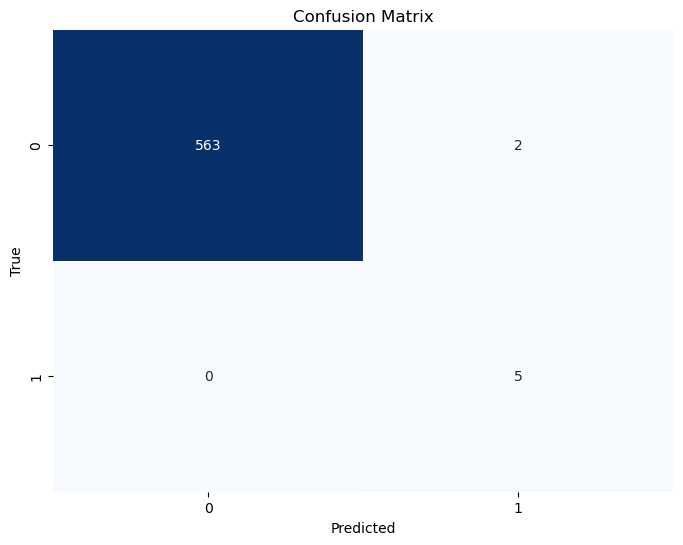

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       565
         1.0       0.71      1.00      0.83         5

    accuracy                           1.00       570
   macro avg       0.86      1.00      0.92       570
weighted avg       1.00      1.00      1.00       570



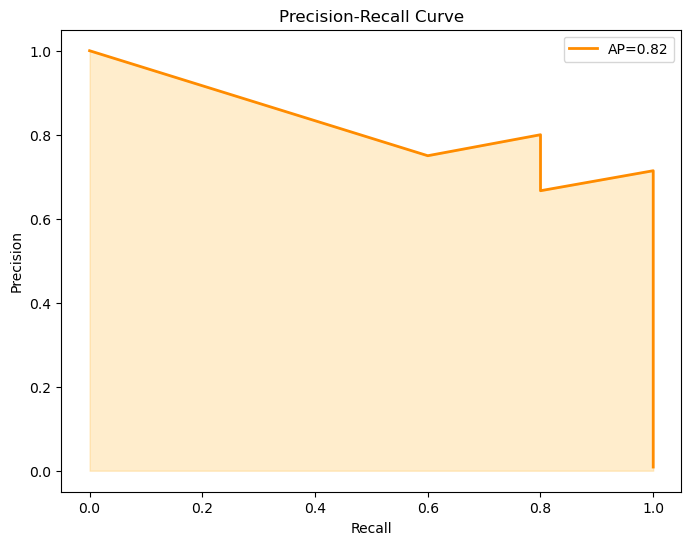

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

conf_matrix = confusion_matrix(y_test, predthr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_test, predthr))
print(accuracy_score(y_test, predthr))

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
average_precision = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'AP={average_precision:.2f}')
plt.fill_between(recall, precision, alpha=0.2, color='orange')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.show()
